# Notebook Used to Vizualize the Output of Sequentially Saved Learning

In [1]:
from tqdm import tqdm
from scipy.spatial import distance
from dap import DAPcython
from dap.utils import obs_params, load_current
from utils import calc_features_ramp, calc_features_step

import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### Get the dir names

In [48]:
# load the file
directory = './parameters/'
dir = glob.glob(directory + '*')
fname = dir[0] + '/'

In [49]:
fname

'./parameters/dap_model_5_param_3x30/'

## Load The Recorded Means and Std
'hyperparam.csv'
'parameters_mean.csv'
'parameters_std.csv'

In [6]:
df_std = pd.read_csv(fname + 'parameters_std' + '.csv')
df_mean = pd.read_csv(fname + 'parameters_mean' + '.csv')
df_hyperparam = pd.read_csv(fname + 'hyperparam' + '.csv')

In [7]:
df_mean.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_std.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_mean.set_index('id', inplace=True)
df_std.set_index('id', inplace=True)


In [8]:
df_mean.drop(13, inplace=True)

In [9]:
# df_std.head()

In [10]:
df_hyperparam

,Unnamed: 0,name,n_rounds,n_summary,n_samples,n_hidden,n_components,protocol,ramp_amp,prior_min,prior_max
0,0,_5_param_3x30,20,17,1000,"[30, 30, 30]",1,rampIV,3.1,"[0, 1]","[0.5, 30]"


### Simulate For Each Parameter Set

### calculate DAP

In [52]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

In [12]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U_ramp = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

In [13]:
# get traces for both currents
U_steps, U_ramps = [], []

for i, j in tqdm(df_mean.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    dap = DAPcython(-75, j)

    # run model
    U_step_x = dap.simulate(dts, ts, Is)
    U_ramp_x = dap.simulate(dtr, tr, Ir)

    # run model
    U_steps.append(U_step_x.transpose()[0])
    U_ramps.append(U_ramp_x.transpose()[0])

19it [00:20,  1.06s/it]


### Viz all simulations

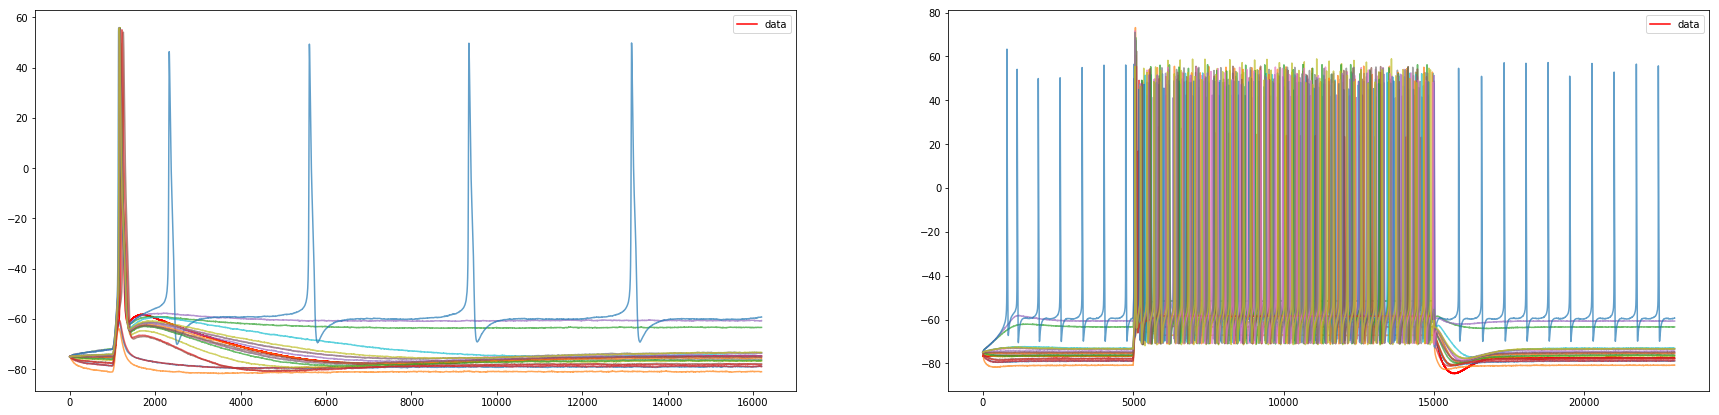

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, trace in enumerate(U_ramps): 
    ax[0].plot(trace, alpha=0.7)

for i, trace in enumerate(U_steps): 
    ax[1].plot(trace, alpha=0.7)
    
ax[0].legend()
ax[1].legend();


## Calculate Similarity by Features

In [15]:
# create DataFrames for traces
df_step = pd.DataFrame({'step_traces': U_steps})
df_step.set_index(df_mean.index.values, inplace=True)

df_ramp = pd.DataFrame({'ramp_traces': U_ramps})
df_ramp.set_index(df_mean.index.values, inplace=True)

In [16]:
df_traces_temp = pd.merge(df_mean, df_step, how='left', left_index=True, right_index=True)
df_traces = pd.merge(df_traces_temp, df_ramp, how='left', left_index=True, right_index=True)

In [17]:
# Calculate Statistics for Ramp and Step currents
step_features_labels = ['rest_pot', 'rest_pot_std','firing_rate', 'ISI_mean', 'ISI_std', 'spike_count', 'spike_times_stim']
ramp_features_labels = ['rest_pot', 'AP_amp', 'AP_width', 'fAHP', 'DAP_amp', 'DAP_width', 'DAP_deflection','DAP_time', 'mAHP']

In [18]:
stats_step = []
for i,u in enumerate(U_steps):
    stats = calc_features_step(u, ts, dts, t_ons, t_offs)
    stats_step.append(stats)

In [19]:
stats_ramp = []
for i,u in enumerate(U_ramps):
    stats = calc_features_ramp(u, tr, dtr, t_onr, t_offr)
    stats_ramp.append(stats)

In [20]:
# change into data frame
df_ramps = pd.DataFrame(data=stats_ramp, columns=ramp_features_labels, index=df_mean.index)
df_steps = pd.DataFrame(data=stats_step, columns=step_features_labels, index=df_mean.index)

## Calculate The Features

In [21]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [22]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [23]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [24]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


### Pick The Best For Both Currents

In [25]:
n = 4
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [26]:
df_diff_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
0,4,15.066076,0.028166,44.0,9.756184,5.975620,22.0,78.826045
1,6,1.467232,0.026316,4.0,1.365739,4.809475,2.0,17.668762
2,7,0.835107,0.027378,22.0,6.033504,3.390787,11.0,39.286776
3,8,0.021844,0.032761,28.0,7.450118,3.625937,14.0,47.130659
4,9,3.677333,0.020542,58.0,11.088085,5.858851,29.0,87.644812
5,10,18.107253,15.858472,74.0,12.321739,6.050988,37.0,136.338452
6,11,1.274293,0.023811,32.0,7.961483,1.748900,16.0,54.008486
7,12,0.305600,0.039544,18.0,5.482677,3.190638,9.0,39.018459
8,15,2.176155,0.041568,26.0,7.213406,3.710646,13.0,54.141775
9,16,1.621941,0.025147,20.0,5.950527,3.351298,10.0,46.948913


In [27]:
df_best_ramps

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
6,6,0.035634,15.784088,0.02,4.494923,3.721459,0.12,0.737830,0.75,0.424202,26.088136
7,7,0.483373,16.904143,0.03,4.454938,3.290336,0.72,0.681229,0.91,0.065902,27.539920
15,16,0.014361,16.632159,0.02,4.744455,4.087697,1.32,0.671120,0.96,0.393460,28.843252
12,12,0.691935,17.418430,0.03,4.962526,3.526807,0.55,0.743784,0.92,0.611223,29.454704


In [28]:
df_best_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
1,6,1.467232,0.026316,4.0,1.365739,4.809475,2.0,17.668762
7,12,0.305600,0.039544,18.0,5.482677,3.190638,9.0,39.018459
9,16,1.621941,0.025147,20.0,5.950527,3.351298,10.0,46.948913
2,7,0.835107,0.027378,22.0,6.033504,3.390787,11.0,39.286776


## Merge With DFTraces to Get the best Traces and Parameters

In [29]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [30]:
df_traces.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,step_traces,ramp_traces
id,,,,,,,
0,10.995356,0.937945,17.965843,2.245691,0.053104,"[-74.9936855785066, -75.11019627348837, -75.19...","[-74.99755570794322, -75.03281583227705, -75.0..."
1,10.686955,1.095896,28.935782,3.078770,0.044835,"[-74.98727635839577, -75.17246604264263, -75.3...","[-75.00032918939512, -75.04453482113168, -75.0..."
2,16.832033,1.205391,62.270668,2.951745,0.052803,"[-74.99277284962575, -74.94530752502787, -74.8...","[-74.98754673416539, -74.96933356789505, -74.9..."
3,12.092659,0.989837,69.945570,2.998497,0.057717,"[-75.0011771601592, -75.11087405640569, -75.21...","[-75.00159542063042, -74.98063200145637, -75.0..."
4,17.102570,1.023805,95.218336,3.068262,0.049122,"[-74.99799195451575, -74.93391811108461, -74.8...","[-74.99373836932129, -75.00643478810235, -74.9..."


In [31]:
df_best_ramps.head()

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
6,6,0.035634,15.784088,0.02,4.494923,3.721459,0.12,0.737830,0.75,0.424202,26.088136
7,7,0.483373,16.904143,0.03,4.454938,3.290336,0.72,0.681229,0.91,0.065902,27.539920
15,16,0.014361,16.632159,0.02,4.744455,4.087697,1.32,0.671120,0.96,0.393460,28.843252
12,12,0.691935,17.418430,0.03,4.962526,3.526807,0.55,0.743784,0.92,0.611223,29.454704


In [32]:
# df_best_ramps.index.rename('id', inplace=True)
df_best_ramps.set_index('id', inplace=True)
df_best_steps.set_index('id', inplace=True)

In [33]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps, left_index=True, right_index=True)
df_best_ramp_tr.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,step_traces,ramp_traces,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
id,,,,,,,,,,,,,,,,,
6,15.137547,1.036702,115.921851,3.122382,0.054745,"[-74.99407249352289, -75.0053219934725, -75.01...","[-74.99274137853155, -75.00319343433011, -74.9...",0.035634,15.784088,0.02,4.494923,3.721459,0.12,0.737830,0.75,0.424202,26.088136
7,14.692306,1.155554,129.236445,3.011766,0.052186,"[-75.01038993977018, -74.99822014953294, -75.0...","[-75.0010280507964, -75.00922742407394, -75.01...",0.483373,16.904143,0.03,4.454938,3.290336,0.72,0.681229,0.91,0.065902,27.539920
12,14.838997,1.094718,137.708687,3.100020,0.047700,"[-75.01810034145058, -75.03731383174708, -75.0...","[-74.99404015449582, -75.01640399907157, -75.0...",0.691935,17.418430,0.03,4.962526,3.526807,0.55,0.743784,0.92,0.611223,29.454704
16,15.368466,1.062370,136.723324,3.186938,0.052633,"[-74.9985179335877, -74.98538478831478, -74.97...","[-74.99455929737552, -74.98085608719367, -75.0...",0.014361,16.632159,0.02,4.744455,4.087697,1.32,0.671120,0.96,0.393460,28.843252


In [34]:
df_best_steps

,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
id,,,,,,,
6,1.467232,0.026316,4.0,1.365739,4.809475,2.0,17.668762
12,0.305600,0.039544,18.0,5.482677,3.190638,9.0,39.018459
16,1.621941,0.025147,20.0,5.950527,3.351298,10.0,46.948913
7,0.835107,0.027378,22.0,6.033504,3.390787,11.0,39.286776


In [35]:

df_best_step_tr = pd.merge(df_traces, df_best_steps, left_index=True, right_index=True)
df_best_step_tr

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,step_traces,ramp_traces,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
id,,,,,,,,,,,,,,
6,15.137547,1.036702,115.921851,3.122382,0.054745,"[-74.99407249352289, -75.0053219934725, -75.01...","[-74.99274137853155, -75.00319343433011, -74.9...",1.467232,0.026316,4.0,1.365739,4.809475,2.0,17.668762
7,14.692306,1.155554,129.236445,3.011766,0.052186,"[-75.01038993977018, -74.99822014953294, -75.0...","[-75.0010280507964, -75.00922742407394, -75.01...",0.835107,0.027378,22.0,6.033504,3.390787,11.0,39.286776
12,14.838997,1.094718,137.708687,3.100020,0.047700,"[-75.01810034145058, -75.03731383174708, -75.0...","[-74.99404015449582, -75.01640399907157, -75.0...",0.305600,0.039544,18.0,5.482677,3.190638,9.0,39.018459
16,15.368466,1.062370,136.723324,3.186938,0.052633,"[-74.9985179335877, -74.98538478831478, -74.97...","[-74.99455929737552, -74.98085608719367, -75.0...",1.621941,0.025147,20.0,5.950527,3.351298,10.0,46.948913


## Visualize Best Results of Given Batch

### Ramp Current

In [42]:
df_best_ramp_tr

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,step_traces,ramp_traces,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
id,,,,,,,,,,,,,,,,,
6,15.137547,1.036702,115.921851,3.122382,0.054745,"[-74.99407249352289, -75.0053219934725, -75.01...","[-74.99274137853155, -75.00319343433011, -74.9...",0.035634,15.784088,0.02,4.494923,3.721459,0.12,0.737830,0.75,0.424202,26.088136
7,14.692306,1.155554,129.236445,3.011766,0.052186,"[-75.01038993977018, -74.99822014953294, -75.0...","[-75.0010280507964, -75.00922742407394, -75.01...",0.483373,16.904143,0.03,4.454938,3.290336,0.72,0.681229,0.91,0.065902,27.539920
12,14.838997,1.094718,137.708687,3.100020,0.047700,"[-75.01810034145058, -75.03731383174708, -75.0...","[-74.99404015449582, -75.01640399907157, -75.0...",0.691935,17.418430,0.03,4.962526,3.526807,0.55,0.743784,0.92,0.611223,29.454704
16,15.368466,1.062370,136.723324,3.186938,0.052633,"[-74.9985179335877, -74.98538478831478, -74.97...","[-74.99455929737552, -74.98085608719367, -75.0...",0.014361,16.632159,0.02,4.744455,4.087697,1.32,0.671120,0.96,0.393460,28.843252


In [36]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.index

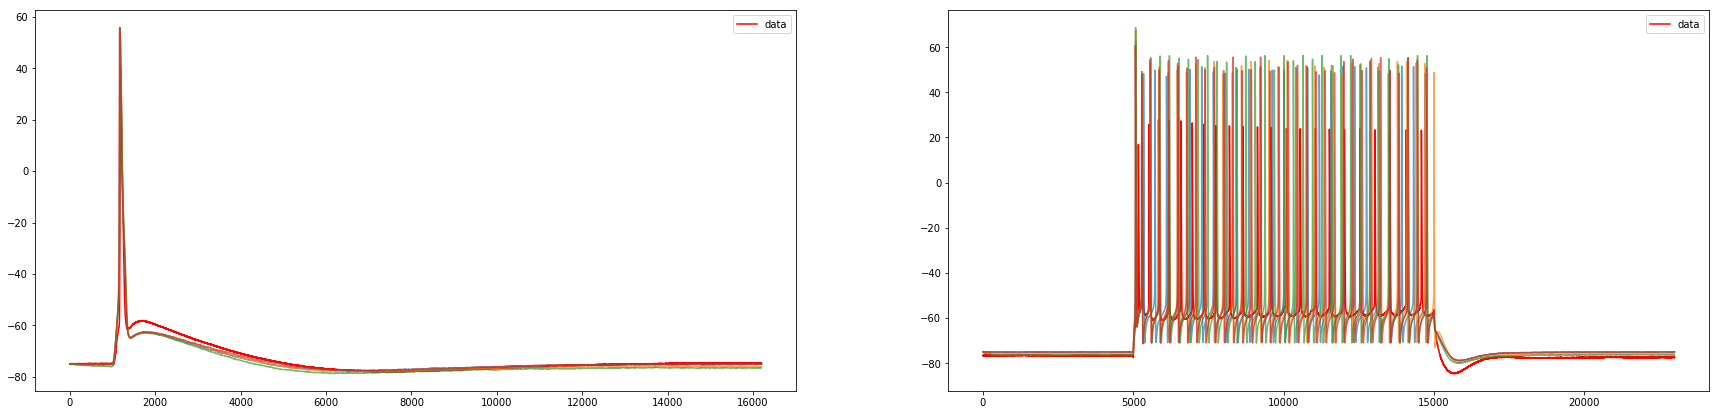

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');

ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    ax[0].plot(tr, alpha=0.7)

for i, tr in enumerate(traces_step): 
    ax[1].plot(tr, alpha=0.7)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [38]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.index

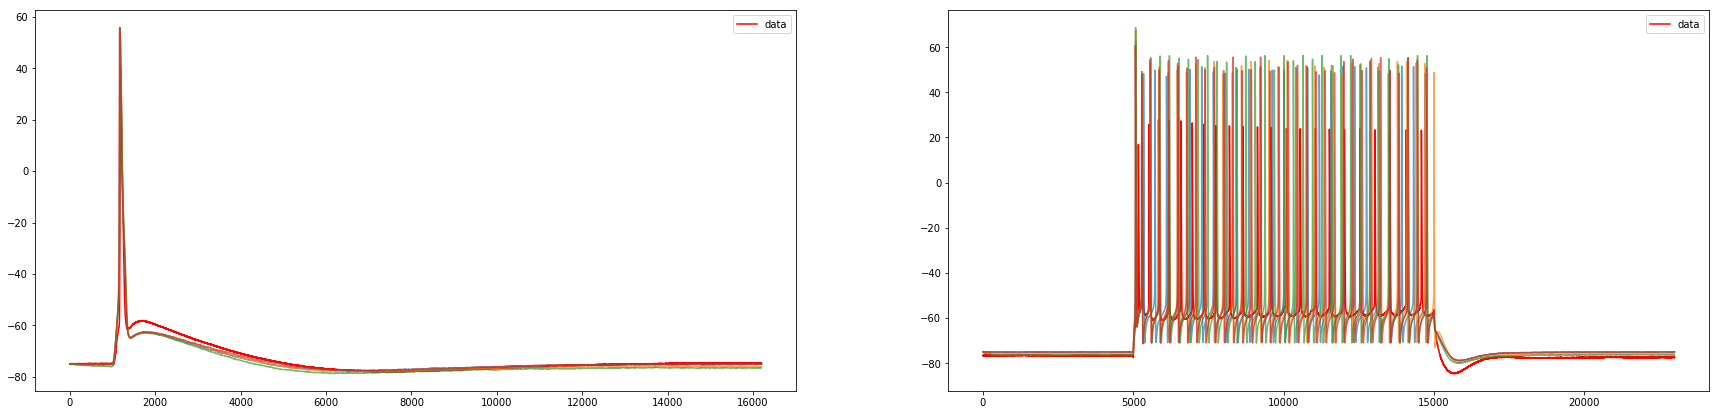

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    ax[0].plot(tr, alpha=0.7)

for i, tr in enumerate(traces_step): 
    ax[1].plot(tr, alpha=0.7)
    
ax[0].legend()
ax[1].legend();


### Show the best Results

In [40]:
n=6
u_ramp = df_best_step_tr.loc[[n]].ramp_traces[n]
u_step = df_best_step_tr.loc[[n]].step_traces[n]

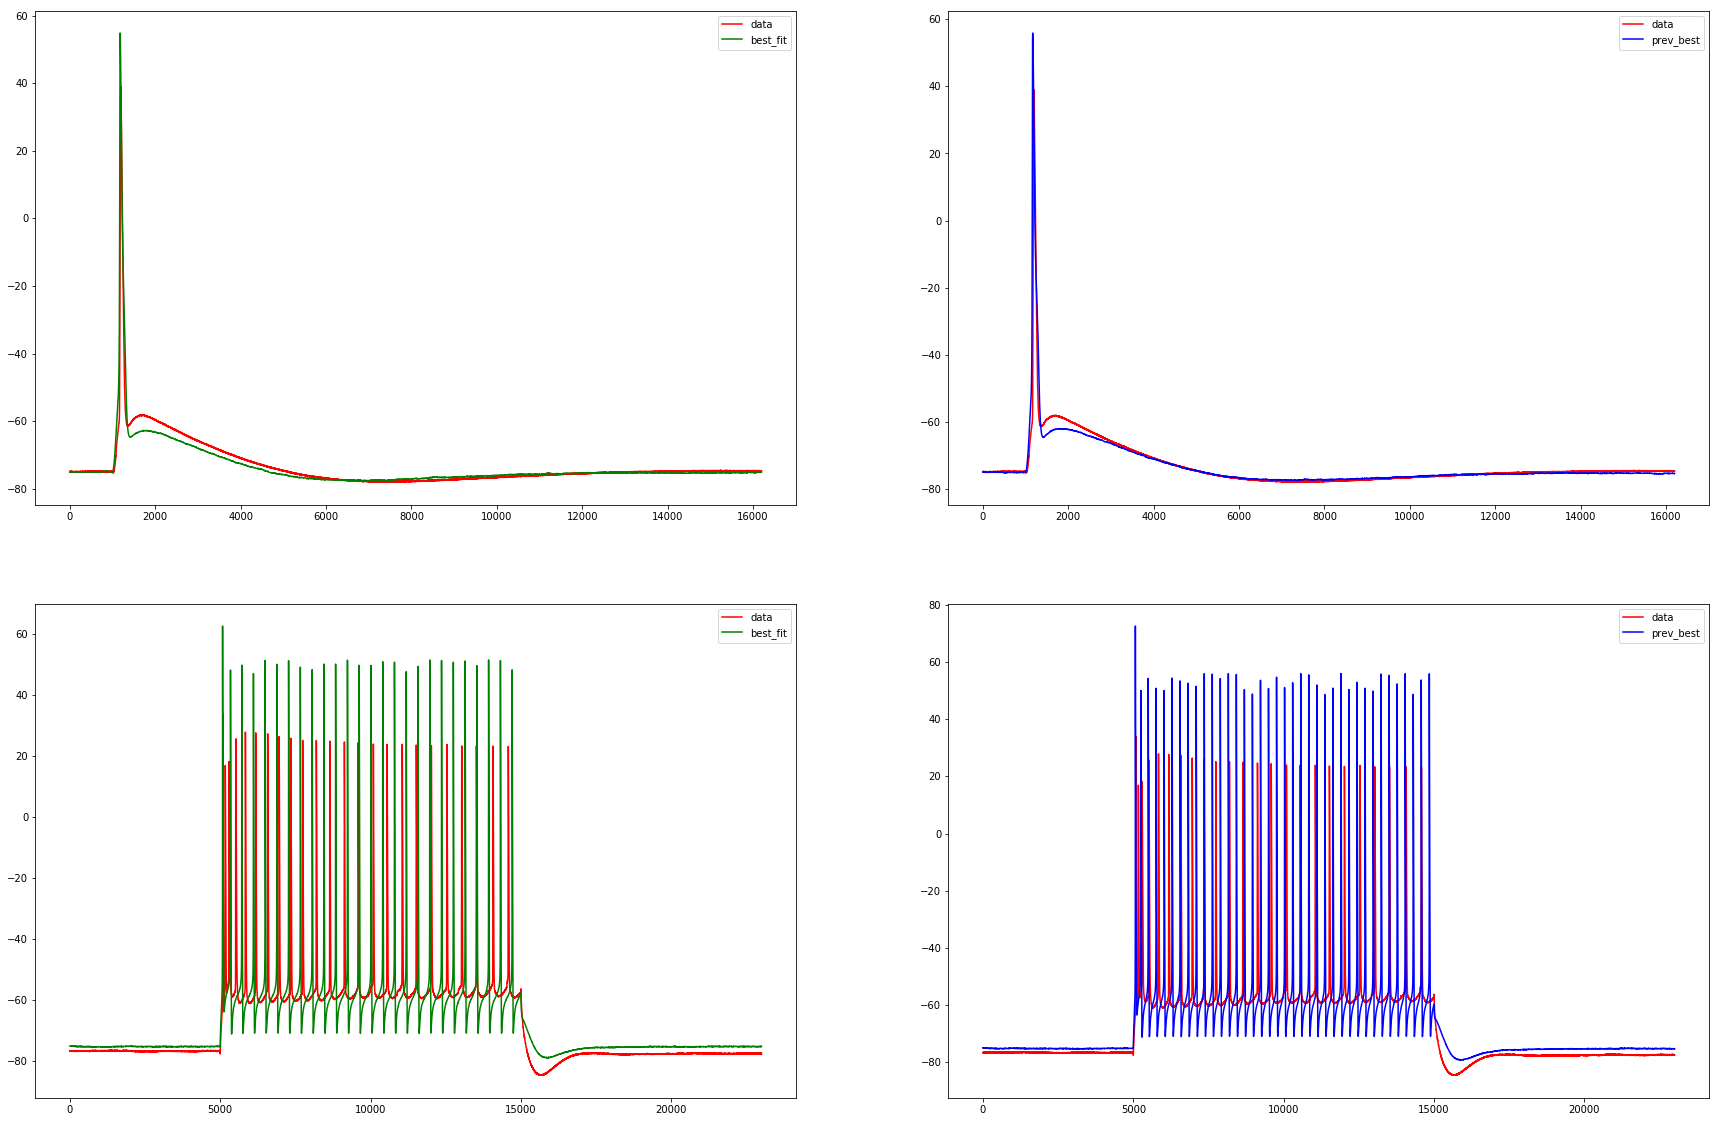

In [45]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].plot(vr, c='r', label='data');
ax[0][1].plot(vr, c='r', label='data');
ax[1][0].plot(vs, c='r', label='data');
ax[1][1].plot(vs, c='r', label='data');

ax[0][0].plot(u_ramp, c='g', label='best_fit');
ax[1][0].plot(u_step, c='g', label='best_fit');

ax[0][1].plot(U_ramp, c='b', label='prev_best');
ax[1][1].plot(U_step, c='b', label='prev_best');

    
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend();
ax[1][1].legend();

### Ramp Best Fit

In [46]:
nn = 7
u_ramp = df_best_ramp_tr.loc[[nn]].ramp_traces[nn]
u_step = df_best_ramp_tr.loc[[nn]].step_traces[nn]

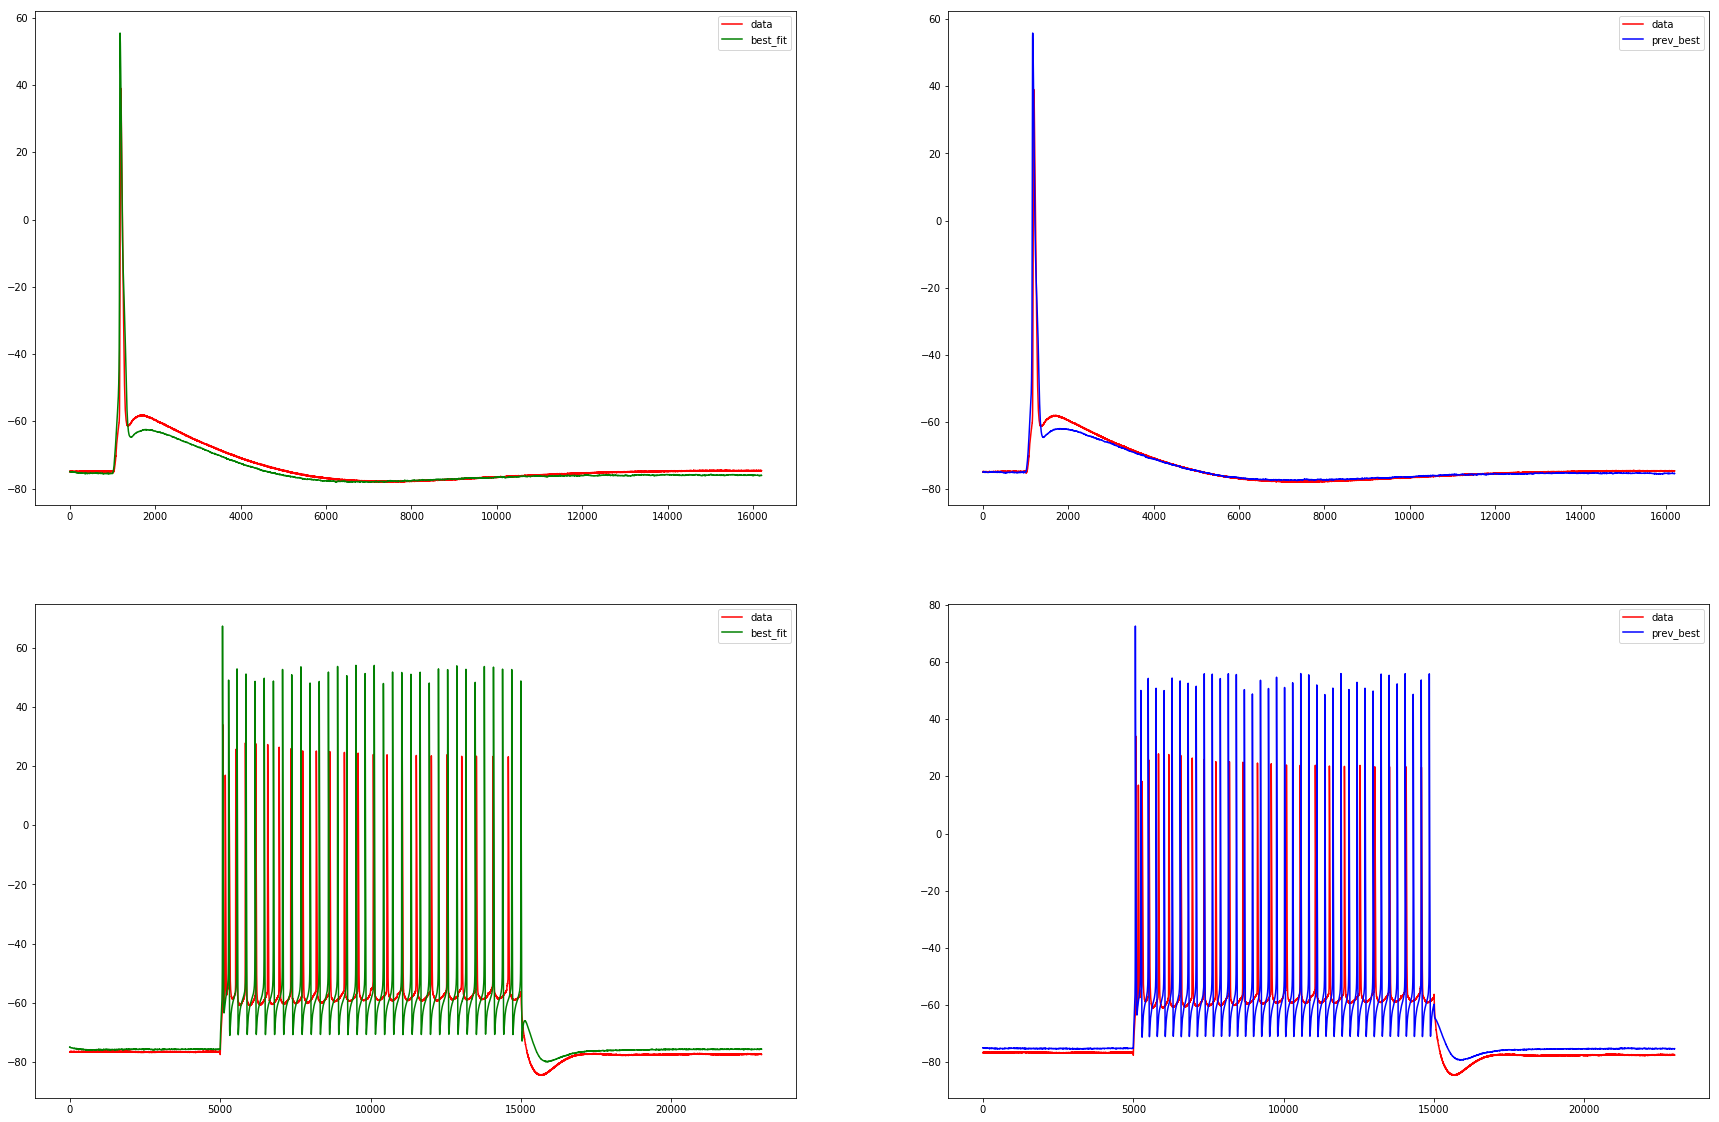

In [47]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].plot(vr, c='r', label='data');
ax[0][1].plot(vr, c='r', label='data');
ax[1][0].plot(vs, c='r', label='data');
ax[1][1].plot(vs, c='r', label='data');

ax[0][0].plot(u_ramp, c='g', label='best_fit');
ax[1][0].plot(u_step, c='g', label='best_fit');

ax[0][1].plot(U_ramp, c='b', label='prev_best');
ax[1][1].plot(U_step, c='b', label='prev_best');

    
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend();
ax[1][1].legend();

### Phase Plane: V ; dV/dt

In [84]:
dvdt = np.gradient(u_ramp, dtr)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(tr, U_ramp);
ax[1].plot(dvdt);

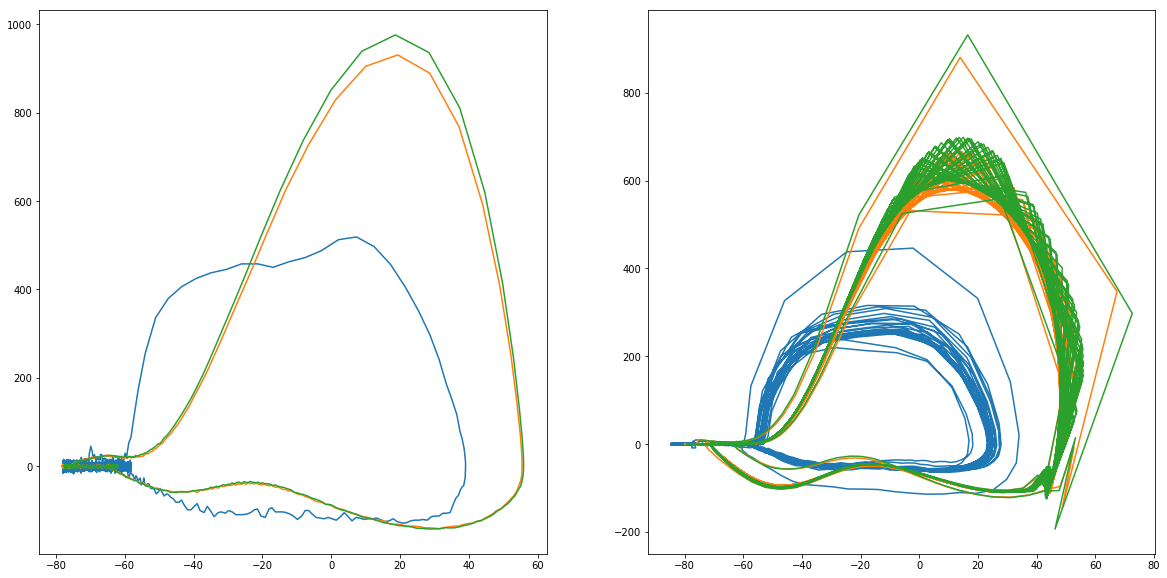

In [103]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

ax[0].plot(vr, np.gradient(vr, dtr));
ax[0].plot(u_ramp, np.gradient(u_ramp, dtr));
ax[0].plot(U_ramp, np.gradient(U_ramp.T[0], dtr));

ax[1].plot(vs, np.gradient(vs, dts), );
ax[1].plot(u_step, np.gradient(u_step, dts));
ax[1].plot(U_step, np.gradient(U_step.T[0], dts));